<a href="https://colab.research.google.com/github/KayalvizhiT513/Financial-Discrepancy-Detection-with-C4.5/blob/main/C4_5_Algorithm_code_DT_%26_PR_with_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import math
import pandas as pd
from math import log2
import numpy as np
import copy
from scipy.optimize import minimize_scalar
from scipy.stats import binom

In [2]:
class TreeNode:
    def __init__(self, label=None, attribute=None, branches=None):
        self.label = label
        self.attribute = attribute
        self.branches = branches or {}

    def get_label(self):
        if self.label is not None:
            return str(self.label)
        elif self.attribute is not None:
            return str(self.attribute)
        else:
            return ""

    def is_leaf(self):
        return not bool(self.branches)

    def add_to_dot(self, dot):
        node_id = str(id(self))
        label = str(self.get_label())  # Ensure label is a string

        if self.is_leaf():
            # Set shape to rectangle for leaf nodes
            dot.node(node_id, label=label, shape='rectangle')
        else:
            dot.node(node_id, label=label)

        for branch_label, branch in self.branches.items():
            branch.add_to_dot(dot)
            dot.edge(node_id, str(id(branch)), label=str(branch_label))  # Ensure branch label is a string



In [3]:
def c45(examples, target_attribute, attributes, validation_data=None, root=None):
    root = TreeNode()

    # If all examples are positive, return a single-node tree with label = 'Play'
    if all(example[target_attribute] == 'Pass' for example in examples if example['weight'] == 1 or example['weight'] == 0):
        weight_sum = sum(example['weight'] for example in examples)
        error_sum = sum(example['weight'] for example in examples if not (example[target_attribute] == 'Pass'))
        root.label = f'Pass ({weight_sum:.1f}/{error_sum:.1f})'

    # If all examples are negative, return a single-node tree with label = "Don't Play"
    elif all(example[target_attribute] == 'Fail' for example in examples if example['weight'] == 1 or example['weight'] == 0):
        weight_sum = sum(example['weight'] for example in examples)
        error_sum = sum(example['weight'] for example in examples if not (example[target_attribute] == 'Fail'))
        root.label = f'Fail ({weight_sum:.1f}/{error_sum:.1f})'

    # If attributes is empty, return a single-node tree with label = most common value of Targetattribute
    elif not attributes:
        root.label = most_common_value(examples, target_attribute)

    else:
        # Choose the best attribute to split on
        best_attribute, threshold = choose_best_attribute(examples, target_attribute, attributes)

        examples_with_nan = [example for example in examples if pd.isna(example.get(best_attribute))]
        examples_not_nan = [example for example in examples if not pd.isna(example.get(best_attribute))]
        len_of_not_null = len(examples_not_nan)

        for example in examples_not_nan:
            if example['weight'] == 0:
                example['weight'] = 1
            else:
                example['weight'] *= 1

        # Split the examples based on the chosen attribute
        subsets = {}
        if attribute_type_mapping[best_attribute] == 0:
            root.attribute = best_attribute
            attribute_values = attributes_dict[best_attribute]
            for value in attribute_values:
                subsets[value] = [example for example in examples_not_nan if example[best_attribute] == value]
                len_of_attr_val = sum(1 for example in examples_not_nan if example[best_attribute] == value)
                if len_of_not_null != 0:
                    w = len_of_attr_val/len_of_not_null
                    ex_copy = copy.deepcopy(examples_with_nan)
                    for example in ex_copy:
                        example['weight'] = w

                    subsets[value].extend(ex_copy)
                else:
                    subsets[value] = [example for example in examples_with_nan if example[best_attribute] == value]
        else:
            subsets['yes'] = [example for example in examples if float(example[best_attribute]) <= threshold]
            subsets['no'] = [example for example in examples if float(example[best_attribute]) > threshold]
            best_attribute = f"{best_attribute} <= {threshold}"
            root.attribute = best_attribute
            attributes_dict[best_attribute] = ['yes', 'no']

        for value in subsets:
            if not subsets[value]:
                # If subset is empty, add a leaf node with label = most common value of Targetattribute
                leaf = TreeNode(label=most_common_value(examples, target_attribute))
                root.branches[value] = leaf
            else:
                # Recursively add subtree
                subtree = c45(subsets[value], target_attribute, [attr for attr in attributes if attr != best_attribute])
                root.branches[value] = subtree

    return root


In [4]:
def most_common_value(examples, target_attribute):
    # Return the most common value of the target attribute in the given examples
    positive_count = sum(1 for example in examples if example[target_attribute] == 'Pass')
    negative_count = sum(1 for example in examples if example[target_attribute] == "Fail")
    return 'Pass' if positive_count >= negative_count else "Fail"


In [5]:
# Function to compute entropy of a set
def compute_entropy(labels):
    unique_labels = labels.unique()
    entropy = 0.0

    for label in unique_labels:
        prob = (labels == label).sum() / len(labels)
        if prob != 0:
            entropy -= prob * log2(prob)

    return entropy

# Function to compute entropy of a split
def compute_split_entropy(left_labels, right_labels, target_column):
    total_length = len(left_labels) + len(right_labels)
    left_weight = len(left_labels) / total_length
    right_weight = len(right_labels) / total_length

    left_entropy = compute_entropy(left_labels[target_column])
    right_entropy = compute_entropy(right_labels[target_column])

    split_entropy = left_weight * left_entropy + right_weight * right_entropy
    return split_entropy

# Function to compute split information for gain ratio
def compute_split_info(left_subset, right_subset, continuous_attribute):
    total_length = len(left_subset) + len(right_subset)
    left_weight = len(left_subset) / total_length
    right_weight = len(right_subset) / total_length

    left_values = left_subset[continuous_attribute].unique()
    right_values = right_subset[continuous_attribute].unique()

    left_info = -sum((len(left_subset[left_subset[continuous_attribute] == value]) / len(left_subset)) * log2(len(left_subset[left_subset[continuous_attribute] == value]) / len(left_subset)) for value in left_values if len(left_subset[left_subset[continuous_attribute] == value]) > 0)

    right_info = -sum((len(right_subset[right_subset[continuous_attribute] == value]) / len(right_subset)) * log2(len(right_subset[right_subset[continuous_attribute] == value]) / len(right_subset)) for value in right_values if len(right_subset[right_subset[continuous_attribute] == value]) > 0)

    split_info = left_weight * left_info + right_weight * right_info
    return split_info



In [6]:
def compute_categorical_gain_ratio(subset, target_column, attribute):
    subset = pd.DataFrame(subset)
    initial_entropy = compute_entropy(subset[target_column])

    # Extract unique values of the 'attribute' from a subset, remove occurrences of 'nan', and calculates the fraction (F) of non-'nan' values
    attribute_values = subset[attribute].unique()
    attribute_values_without_nan = attribute_values[pd.notna(attribute_values)]
    F = len(attribute_values_without_nan)/len(attribute_values)

    weighted_entropy = 0.0
    split_info = 0.0
    gives_a_pure_node = False

    for value in attribute_values_without_nan:
        if pd.isna(value):
            value_subset = subset[pd.isna(subset[attribute])]
        else:
            value_subset = subset[subset[attribute] == value]
        value_weight = len(value_subset) / len(subset)

        value_entropy = compute_entropy(value_subset[target_column])
        weighted_entropy += value_weight * value_entropy
        # To find whether there is pure split in atleast one node
        if value_entropy == 0:
            gives_a_pure_node = True

        split_info -= value_weight * log2(value_weight)

    gain = F*(initial_entropy - weighted_entropy)
    # print("Gain ====",attribute, " : ", gain)
    gain_ratio = gain / split_info if split_info != 0 else 0.0

    return gain_ratio, gives_a_pure_node, gain


def calculate_continuous_gain_ratio(examples, target_attribute, attribute):

    # Specify the continuous attribute and the target column
    continuous_attribute = attribute
    target_column = target_attribute

    df = pd.DataFrame(examples)

    # Sort the DataFrame based on the continuous attribute
    df_sorted = df.sort_values(by=continuous_attribute)

    # Compute initial entropy before the split
    initial_entropy = compute_entropy(df_sorted[target_column])

    # Initialize variables to keep track of best split
    best_gain_ratio = 0.0
    best_threshold = None

    # Iterate through possible split points
    for i in range(1, len(df_sorted)):
        #if df_sorted.iloc[i - 1][continuous_attribute] == df_sorted.iloc[i][continuous_attribute]:
        #    continue
        threshold = (float(df_sorted.iloc[i - 1][continuous_attribute]) + float(df_sorted.iloc[i][continuous_attribute])) / 2.0

        # Split the data into two subsets based on the threshold
        left_subset = df_sorted[df_sorted[continuous_attribute] <= threshold]
        right_subset = df_sorted[df_sorted[continuous_attribute] > threshold]

        # Calculate gain and split information for the current split
        gain = initial_entropy - compute_split_entropy(left_subset, right_subset, target_column)
        split_info = compute_split_info(left_subset, right_subset, continuous_attribute)

        # Calculate gain ratio
        gain_ratio = gain / split_info if split_info != 0 else 0.0

        # Update best split if gain ratio is higher
        if gain_ratio > best_gain_ratio:
            best_gain_ratio = gain_ratio
            best_threshold = threshold

    # Return the maximum gain ratio
    return best_gain_ratio, best_threshold



In [7]:
def choose_best_attribute(examples, target_attribute, attributes):
    best_attribute = None
    best_gain_ratio = -1
    threshold = -1
    gain_threshold_list = {}
    gives_a_pure_node = False
    attr_gain = {}
    attr_gain_ratio = {}

    for attribute in attributes:
        # Check if the attribute is continuous
        if attribute_type_mapping[attribute] == 1:
            gain_ratio, threshold = calculate_continuous_gain_ratio(examples, target_attribute, attribute)
            gain_threshold_list[gain_ratio] = threshold

        else:
            gain_ratio, gives_a_pure_node, gain = compute_categorical_gain_ratio(examples, target_attribute, attribute)
            gain_threshold_list[gain_ratio] = threshold

        attr_gain[attribute] = gain
        attr_gain_ratio[attribute] = gain_ratio

        if (threshold != -1 or True) and gain_ratio > best_gain_ratio:
            best_gain_ratio = gain_ratio
            best_attribute = attribute
    # if best_attribute == "|Portfolio Return| > 8":
    #    best_attribute = "|Portfolio Return| > 5"
    print("\nBest attribute: ", best_attribute, " : ", best_gain_ratio)

    sorted_attr_gain = sorted(attr_gain.items(), key=lambda item: item[1], reverse=True)
    for key, value in sorted_attr_gain[:3]:
        print(f"Gain: {key} {value}")
    sorted_attr_gain_ratio = sorted(attr_gain_ratio.items(), key=lambda item: item[1], reverse=True)
    for key, value in sorted_attr_gain_ratio[:3]:
        print(f"Gain Ratios: {key} {value}")

    # sort the attr_gain by values and print top 3


    return best_attribute, gain_threshold_list[best_gain_ratio]


In [8]:
def print_leaf(node):
    leaves = []  # Use a Python list, not a NumPy array

    if node.label is not None:
        return [node.label]  # Return a list with the label

    for value, subtree in node.branches.items():
        leaves.extend(print_leaf(subtree))  # Use extend instead of append

    return leaves

In [9]:
def tree_to_rules(node, indent=0, rule_list=None, current_rule=None):
    if rule_list is None:
        rule_list = []

    if current_rule is None:
        current_rule = ""

    if node.label is not None:
        rule_list.append(current_rule + node.label)
    else:
        for value, subtree in node.branches.items():
            new_rule = current_rule + f"If {node.attribute} is {str(value).upper()} then "
            tree_to_rules(subtree, indent + 1, rule_list, new_rule)

    return rule_list


Best attribute:  |Portfolio Return| > 9  :  0.5826433214577509
Gain: |Yesterday's Return - Today's Return| > 2 0.11453935689704695
Gain: Standard Deviation of Portfolio Returns > 1 0.09881962342450432
Gain: |Yesterday's Return - Today's Return| > 3 0.09283255148036945
Gain Ratios: |Portfolio Return| > 9 0.5826433214577509
Gain Ratios: |Portfolio Return| > 10 0.5688057093376809
Gain Ratios: |Yesterday's Return - Today's Return| > 5 0.5688057093376809

Best attribute:  Total Flows/MV > 10  :  0.6117616270288206
Gain: |Yesterday's Return - Today's Return| > 2 0.0861491348873871
Gain: Standard Deviation of Portfolio Returns > 1 0.07604602255738227
Gain: |Yesterday's Return - Today's Return| > 3 0.06792178624449549
Gain Ratios: Total Flows/MV > 10 0.6117616270288206
Gain Ratios: |Yesterday's Return - Today's Return| > 5 0.5940573406138197
Gain Ratios: |Portfolio Return - Benchmark Return| >  4 0.5752351747290202

Best attribute:  |Yesterday's Return - Today's Return| > 5  :  0.634626889271

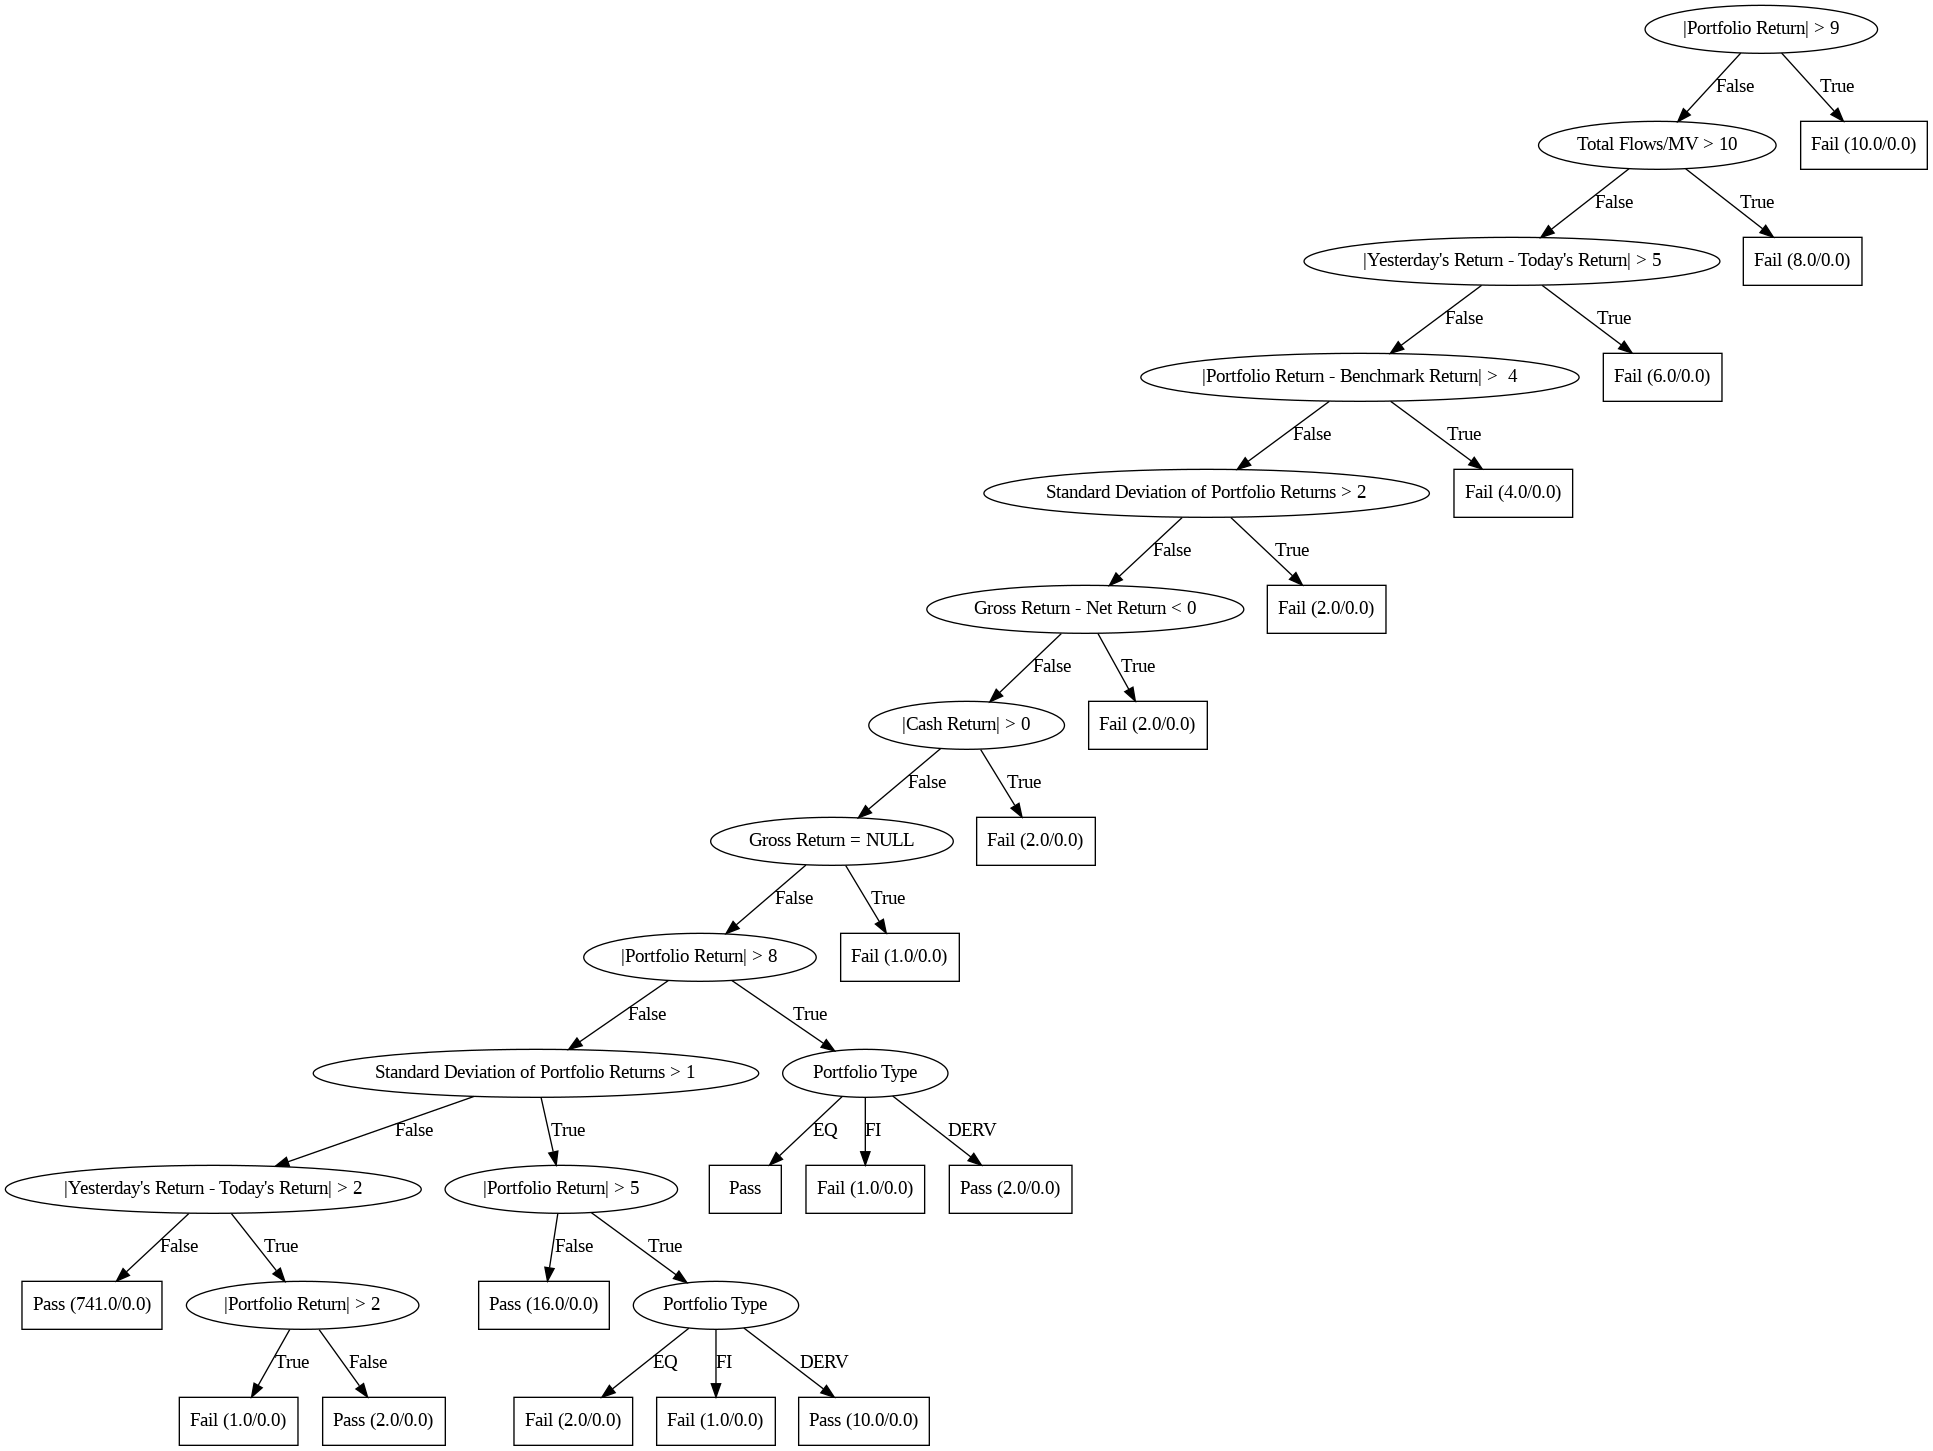

In [10]:
# Load data from Excel file
# file_path = '/content/Categorical valued Dataset.xlsx'
file_path = '/content/V5 Categorical data.xlsx'

df = pd.read_excel(file_path)

# Remove the columns that does not participate in classification
# df = df.drop(['Portfolio Type'], axis = 1)

# Example attributes and target_attribute
attributes = df.columns[:-1].tolist()
target_attribute = df.columns[-1]

# Adding a column named "weight" with default values of 0
df['weight'] = 0

# Create a dictionary with unique attribute values
attributes_dict = {col: df[col].dropna().unique().tolist() for col in df.columns}

# Initialize the attribute type mapping dictionary
attribute_type_mapping = {}

# Iterate over columns and classify attributes
for attribute in df.columns:
    # Check if an attribute is categorical or continuous
    is_float = pd.to_numeric(df[attribute], errors='coerce').notnull().all()
    num_unique_values = df[attribute].nunique()

    if is_float and num_unique_values > 2:
        attribute_type_mapping[attribute] = 1  # Continuous
    else:
        attribute_type_mapping[attribute] = 0  # Categorical

# Example usage
tree = c45(df.to_dict(orient='records'), target_attribute, attributes)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree1', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree1.png')


Best attribute:  |Portfolio Return| > 9  :  0.5826433214577509
Gain: |Yesterday's Return - Today's Return| > 2 0.11453935689704695
Gain: Standard Deviation of Portfolio Returns > 1 0.09881962342450432
Gain: |Yesterday's Return - Today's Return| > 3 0.09283255148036945
Gain Ratios: |Portfolio Return| > 9 0.5826433214577509
Gain Ratios: |Portfolio Return| > 10 0.5688057093376809
Gain Ratios: |Yesterday's Return - Today's Return| > 5 0.5688057093376809

Best attribute:  Total Flows/MV > 10  :  0.6117616270288206
Gain: |Yesterday's Return - Today's Return| > 2 0.0861491348873871
Gain: Standard Deviation of Portfolio Returns > 1 0.07604602255738227
Gain: |Yesterday's Return - Today's Return| > 3 0.06792178624449549
Gain Ratios: Total Flows/MV > 10 0.6117616270288206
Gain Ratios: |Yesterday's Return - Today's Return| > 5 0.5940573406138197
Gain Ratios: |Portfolio Return - Benchmark Return| >  4 0.5752351747290202

Best attribute:  |Yesterday's Return - Today's Return| > 5  :  0.634626889271

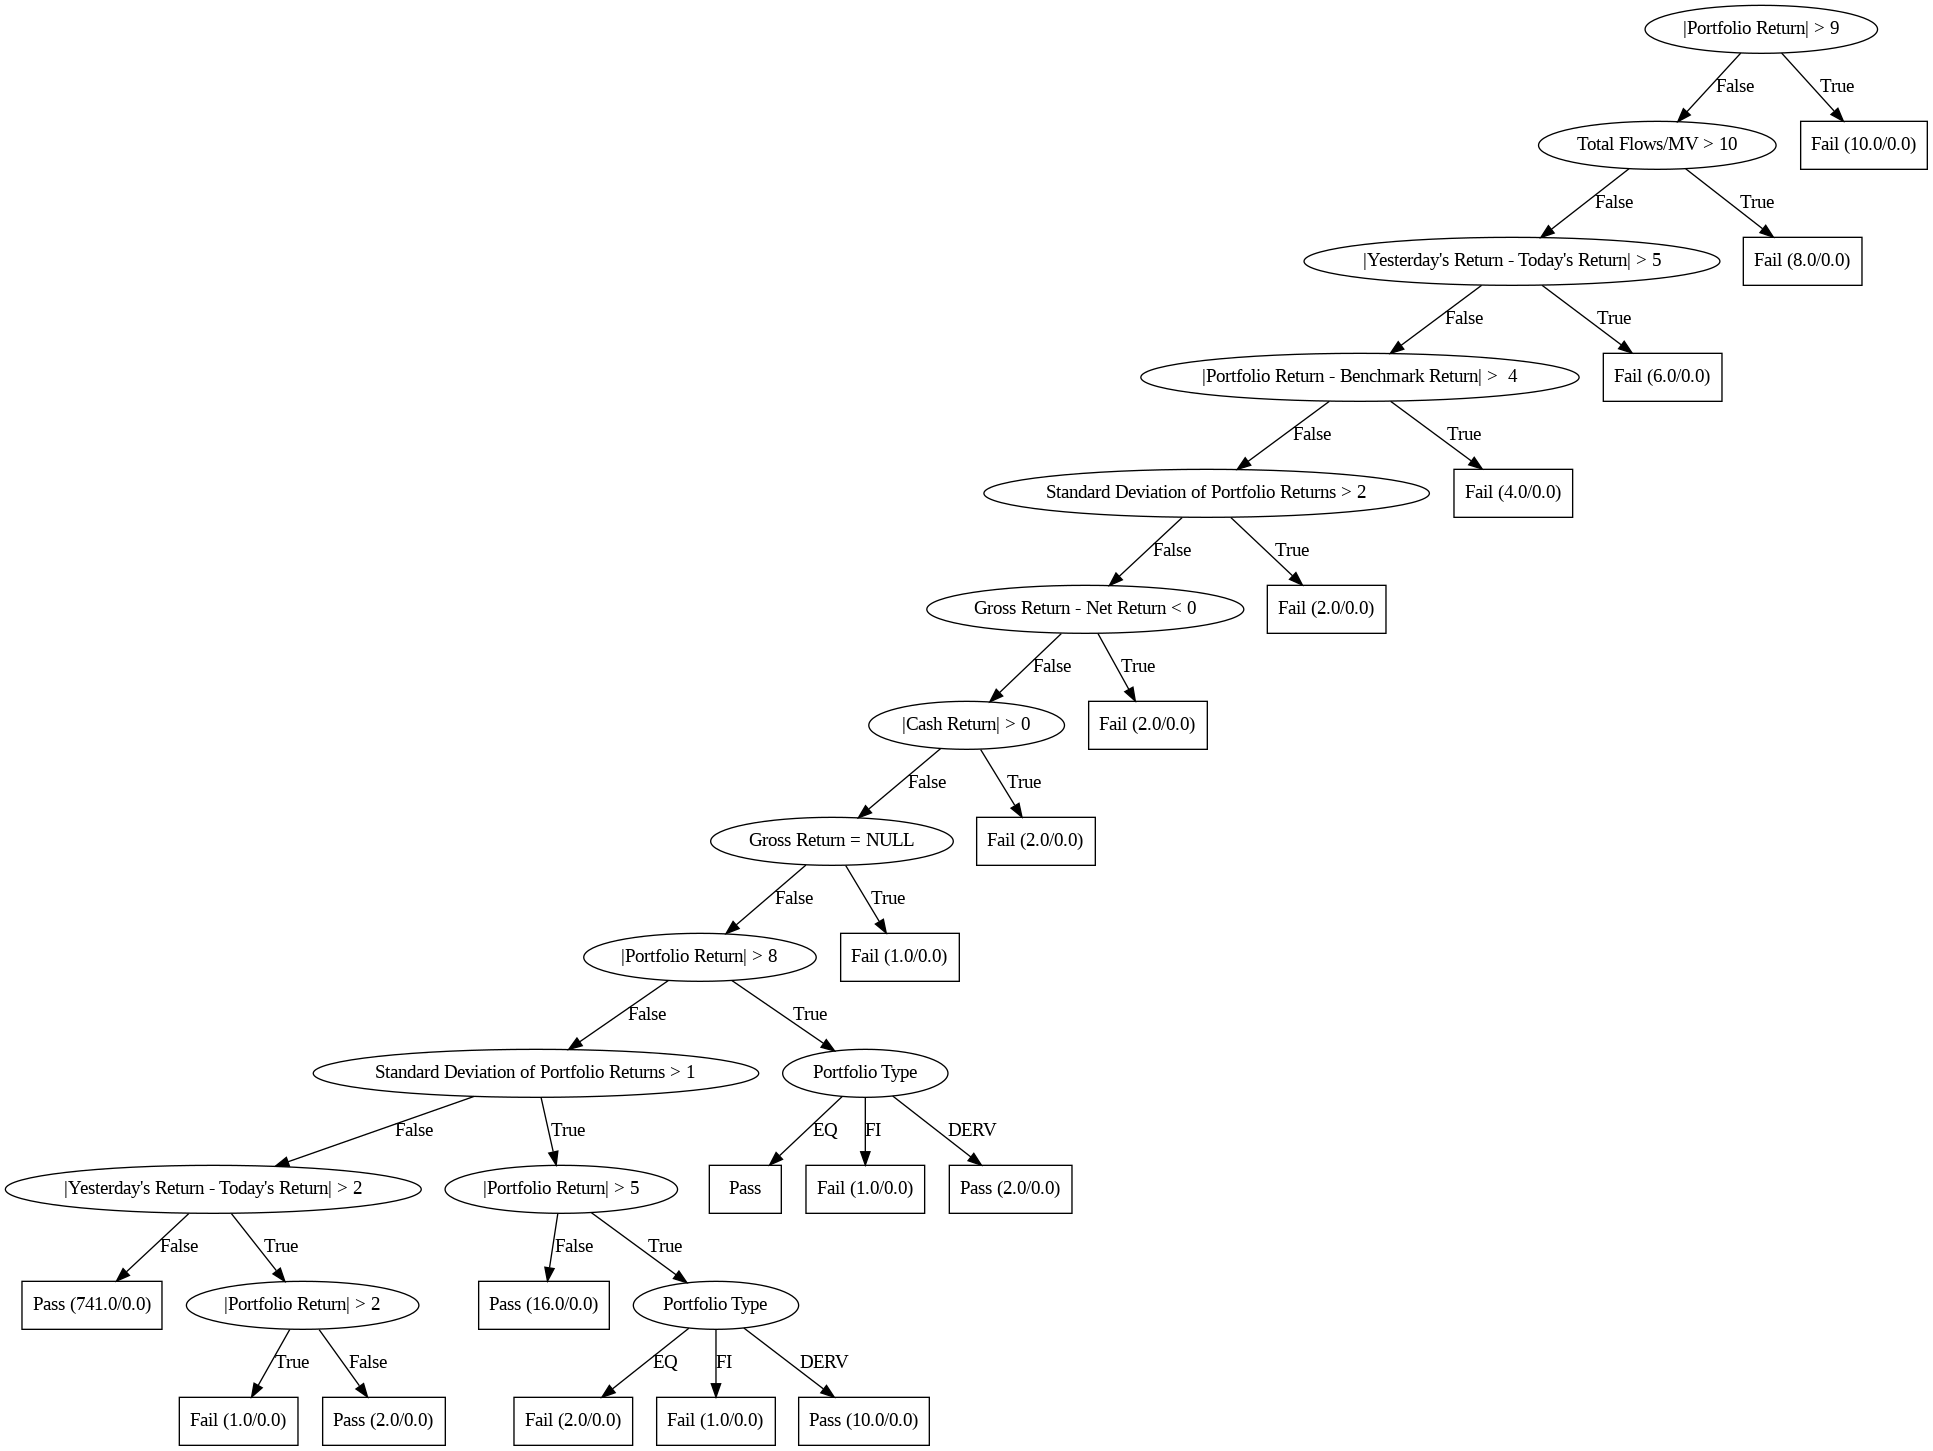

In [11]:
# Load data from Excel file
# file_path = '/content/V5 Categorical data.xlsx'

df = pd.read_excel(file_path)

# Remove the columns that does not participate in classification
# df = df.drop(df.columns[1:8], axis=1)

# Example attributes and target_attribute
attributes = df.columns[:-1].tolist()
target_attribute = df.columns[-1]

# Adding a column named "weight" with default values of 0
df['weight'] = 0

# Create a dictionary with unique attribute values
attributes_dict = {col: df[col].dropna().unique().tolist() for col in df.columns}

# Initialize the attribute type mapping dictionary
attribute_type_mapping = {}

# Iterate over columns and classify attributes
for attribute in df.columns:
    # Check if an attribute is categorical or continuous
    is_float = pd.to_numeric(df[attribute], errors='coerce').notnull().all()
    num_unique_values = df[attribute].nunique()

    if is_float and num_unique_values > 2:
        attribute_type_mapping[attribute] = 1  # Continuous
    else:
        attribute_type_mapping[attribute] = 0  # Categorical

# Example usage
tree = c45(df.to_dict(orient='records'), target_attribute, attributes)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree2', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree2.png')

In [12]:
# Display rules
rules = tree_to_rules(tree)
for rule in rules:
    print(rule)

If |Portfolio Return| > 9 is FALSE then If Total Flows/MV > 10 is FALSE then If |Yesterday's Return - Today's Return| > 5 is FALSE then If |Portfolio Return - Benchmark Return| >  4 is FALSE then If Standard Deviation of Portfolio Returns > 2 is FALSE then If Gross Return - Net Return < 0 is FALSE then If |Cash Return| > 0 is FALSE then If Gross Return = NULL is FALSE then If |Portfolio Return| > 8 is FALSE then If Standard Deviation of Portfolio Returns > 1 is FALSE then If |Yesterday's Return - Today's Return| > 2 is FALSE then Pass (741.0/0.0)
If |Portfolio Return| > 9 is FALSE then If Total Flows/MV > 10 is FALSE then If |Yesterday's Return - Today's Return| > 5 is FALSE then If |Portfolio Return - Benchmark Return| >  4 is FALSE then If Standard Deviation of Portfolio Returns > 2 is FALSE then If Gross Return - Net Return < 0 is FALSE then If |Cash Return| > 0 is FALSE then If Gross Return = NULL is FALSE then If |Portfolio Return| > 8 is FALSE then If Standard Deviation of Portfo

In [13]:
def print_tree(node, indent=0):
    if node.label is not None:
        print("  " * indent + f"Decision: {node.label}")
    else:
        print("  " * indent + f" {node.attribute}")
        for value, subtree in node.branches.items():
            print("  " * (indent + 1) + f"| {value}")
            print_tree(subtree, indent + 2)

In [14]:
def tree_to_rules(node, indent=0, rule_list=None, current_rule=[]):
    if rule_list is None:
        rule_list = []

    if current_rule is None:
        current_rule = ""

    if node.label is not None:
        rule_dict = {}
        rule_dict['rule_num'] = indent
        rule_dict['rules'] = current_rule
        rule_dict['decision'] = node.label
        rule_list.append(rule_dict)
    else:
        for value, subtree in node.branches.items():
            attr_name = f"{node.attribute} is {str(value)}"
            new_rule = current_rule + [attr_name]
            rule_num_list = [rule_dict['rule_num'] for rule_dict in rule_list]
            if rule_num_list:
                indent = max(rule_num_list) + 1
            tree_to_rules(subtree, indent, rule_list, new_rule)

    return rule_list

In [15]:
production_rules = tree_to_rules(tree)

In [16]:
production_rules

[{'rule_num': 0,
  'rules': ['|Portfolio Return| > 9 is False',
   'Total Flows/MV > 10 is False',
   "|Yesterday's Return - Today's Return| > 5 is False",
   '|Portfolio Return - Benchmark Return| >  4 is False',
   'Standard Deviation of Portfolio Returns > 2 is False',
   'Gross Return - Net Return < 0 is False',
   '|Cash Return| > 0 is False',
   'Gross Return = NULL is False',
   '|Portfolio Return| > 8 is False',
   'Standard Deviation of Portfolio Returns > 1 is False',
   "|Yesterday's Return - Today's Return| > 2 is False"],
  'decision': 'Pass (741.0/0.0)'},
 {'rule_num': 1,
  'rules': ['|Portfolio Return| > 9 is False',
   'Total Flows/MV > 10 is False',
   "|Yesterday's Return - Today's Return| > 5 is False",
   '|Portfolio Return - Benchmark Return| >  4 is False',
   'Standard Deviation of Portfolio Returns > 2 is False',
   'Gross Return - Net Return < 0 is False',
   '|Cash Return| > 0 is False',
   'Gross Return = NULL is False',
   '|Portfolio Return| > 8 is False',


In [17]:
from scipy.stats import fisher_exact
import copy  # To create deep copies of nodes

# Fisher's exact test pruning threshold
P_VALUE_THRESHOLD = 0.08

# Function to count decisions for each node (Pass and Fail)
def count_decisions(node):
    decision = node['decision']
    pass_count, fail_count = 0, 0

    # Extract the count of Pass and Fail from the decision string (assumes format 'Pass (X/Y)' or 'Fail (X/Y)')
    if 'Pass' in decision:
        try:
            pass_count = float(decision.split('(')[1].split('/')[0])
            fail_count = float(decision.split('(')[1].split('/')[1].replace(')', '')) if '/' in decision else 0.0
        except:
            pass_count = 0.0
            fail_count = 0.0
    else:  # Fail case
        try:
            fail_count = float(decision.split('(')[1].split('/')[0])
            pass_count = float(decision.split('(')[1].split('/')[1].replace(')', '')) if '/' in decision else 0.0
        except:
            pass_count = 0.0
            fail_count = 0.0
    return pass_count, fail_count

# Function to find the branch with the most matched rules
def find_most_matched_branch(pruned_rules, unpruned_tree):
    max_match_count = 1
    best_match_node = None

    for node in unpruned_tree:
        unpruned_rules = node['rules']
        match_count = len(set(pruned_rules) - set(unpruned_rules))  # Count matching rules
        print("Match count:", match_count)

        if match_count == max_match_count:
            max_match_count = match_count
            best_match_node = node

    return best_match_node

# Function to prune the decision tree using Fisher's exact test and transfer errors to most matched branch
def prune_tree(tree, p_value_threshold=P_VALUE_THRESHOLD):
    rule_num = len(tree)
    pruned_tree = []
    pruned_nodes = []  # To store pruned nodes and transfer their errors later

    # Create a deep copy of the tree to avoid modifying the original list
    working_tree = copy.deepcopy(tree)

    # Calculate total Pass and Fail counts across the entire tree
    total_pass = sum(count_decisions(node)[0] for node in working_tree)
    total_fail = sum(count_decisions(node)[1] for node in working_tree)

    for i, node in enumerate(working_tree):
        pass_count, fail_count = count_decisions(node)

        # calculate pass and fail count on other node
        opp_node = copy.deepcopy(node)
        opp_pass, opp_fail = 0, 0
        # print(node['rules'][-1], "True" in node['rules'][-1])
        if "True" in node['rules'][-1]:
            opp_node['rules'] = node['rules'][:-1]
            opp_node['rules'].append(node['rules'][-1].replace("True", "False"))
        elif "False" in node['rules'][-1]:
            # print(node['rules'][:-1], "\n", node['rules'][-1].replace("False", "True"))
            opp_node['rules'] = node['rules'][:-1]
            opp_node['rules'].append(node['rules'][-1].replace("False", "True"))
        else:
            opp_node['rules'] = node['rules'][:-1]

        if len([rule for rule in working_tree if rule['rules'] == opp_node['rules']]) == 1:
            opp_node = [rule for rule in working_tree if rule['rules'] == opp_node['rules']][0]
            print("Opposite rule list:", opp_node['rules'])
            opp_pass, opp_fail = count_decisions(opp_node)
            print("Opposite pass and fail:", opp_pass, opp_fail)
        else:
            # get the rules for which node["rules"][-1] is a subset
            rule_list = []
            for rule in working_tree:
                if set(node['rules'][:-1]).issubset(set(rule['rules'][:-1])):
                    rule_list.append(rule)
            print("Opposite rule list:", rule_list)
            for rule in rule_list:
                opp_pass += count_decisions(rule)[0]
                opp_fail += count_decisions(rule)[1]
            opp_pass -= pass_count
            opp_fail -= fail_count

        # Set up the contingency table for Fisher's exact test
        contingency_table = [[pass_count, fail_count], [opp_pass, opp_fail]]
        print(contingency_table)

        # Perform Fisher's exact test
        _, p_value = fisher_exact(contingency_table)
        print(f"P-value for node {i}: {p_value}")

        # If the p-value is above the threshold, prune this branch
        if p_value > p_value_threshold:
            print(f"Branch {i} with rules {node['rules']} is pruned (p-value = {p_value})")
            pruned_nodes.append(node)  # Save pruned node for later error transfer
        else:
            pruned_tree.append(node)  # Keep the branch if it's significant

    # Transfer errors from pruned nodes to the most matched unpruned nodes
    while pruned_nodes:
        for pruned_node in pruned_nodes:
            pruned_pass, pruned_fail = count_decisions(pruned_node)
            print("==============================================\n",pruned_node['rule_num'])

            new_node = copy.deepcopy(pruned_node)
            neighbour_node = [node for node in working_tree if len(set(new_node['rules'][:-1]) - set(node['rules'])) == 0]
            print('16.0' in pruned_node['decision'], pruned_node['rule_num'])
            if '16.0' in pruned_node['decision']:
                print("Neighbour nodes:", neighbour_node)
            neighbour_pass = sum(count_decisions(node)[0] for node in neighbour_node)
            neighbour_fail = sum(count_decisions(node)[1] for node in neighbour_node)
            tot_pruned_pass = neighbour_pass
            tot_pruned_fail = neighbour_fail
            if tot_pruned_fail >= tot_pruned_pass:
                new_node['decision'] = f"Fail {tot_pruned_fail}/{tot_pruned_pass}"
                new_node['rules'] = pruned_node['rules'][:-1]
            else:
                new_node['decision'] = f"Pass {tot_pruned_pass}/{tot_pruned_fail}"
                new_node['rules'] = pruned_node['rules'][:-1]

            pruned_tree.append(new_node)
            for node in neighbour_node:
                print("Nodes removed are:", node)
                if node in pruned_nodes:
                    pruned_nodes.remove(node)
                if node['rule_num'] in [node['rule_num'] for node in pruned_tree] and node['rule_num'] != new_node['rule_num']:
                    for node_to_be_removed in pruned_tree:
                        if node['rule_num'] == node_to_be_removed['rule_num']:
                            pruned_tree.remove(node_to_be_removed)

    print("==============================================\n",pruned_nodes)

    return pruned_tree

# Example usage of the pruning function
# production_rules is an input list of dictionary nodes representing the decision tree
pruned_dec_tree = prune_tree(production_rules)

# Print the final pruned tree
print("Final Pruned Tree:")
for node in pruned_dec_tree:
    print(node)

Opposite rule list: [{'rule_num': 0, 'rules': ['|Portfolio Return| > 9 is False', 'Total Flows/MV > 10 is False', "|Yesterday's Return - Today's Return| > 5 is False", '|Portfolio Return - Benchmark Return| >  4 is False', 'Standard Deviation of Portfolio Returns > 2 is False', 'Gross Return - Net Return < 0 is False', '|Cash Return| > 0 is False', 'Gross Return = NULL is False', '|Portfolio Return| > 8 is False', 'Standard Deviation of Portfolio Returns > 1 is False', "|Yesterday's Return - Today's Return| > 2 is False"], 'decision': 'Pass (741.0/0.0)'}, {'rule_num': 1, 'rules': ['|Portfolio Return| > 9 is False', 'Total Flows/MV > 10 is False', "|Yesterday's Return - Today's Return| > 5 is False", '|Portfolio Return - Benchmark Return| >  4 is False', 'Standard Deviation of Portfolio Returns > 2 is False', 'Gross Return - Net Return < 0 is False', '|Cash Return| > 0 is False', 'Gross Return = NULL is False', '|Portfolio Return| > 8 is False', 'Standard Deviation of Portfolio Returns 

In [18]:
def get_or_create_node(parent, value):
    if value not in parent.branches:
        parent.branches[value] = TreeNode()  # Create the node if it doesn't exist
    return parent.branches[value]

def rules_to_tree(rules_list):
    root = TreeNode()

    # Loop through each rule in rules_list
    for rule in rules_list:
        current_node = root

        # Split the rule conditions (attributes and values)
        for condition in rule['rules']:
            attr, val = condition.split(' is ')

            # If this is the first condition, set the attribute of the current node
            if current_node.attribute is None:
                current_node.attribute = attr

            # Get or create the next node based on the value
            current_node = get_or_create_node(current_node, val)

        # After processing all conditions, assign the decision label
        current_node.label = rule['decision']

    return root


Opposite rule list: [{'rule_num': 0, 'rules': ['|Portfolio Return| > 9 is False', 'Total Flows/MV > 10 is False', "|Yesterday's Return - Today's Return| > 5 is False", '|Portfolio Return - Benchmark Return| >  4 is False', 'Standard Deviation of Portfolio Returns > 2 is False', 'Gross Return - Net Return < 0 is False', '|Cash Return| > 0 is False', 'Gross Return = NULL is False', '|Portfolio Return| > 8 is False', 'Standard Deviation of Portfolio Returns > 1 is False', "|Yesterday's Return - Today's Return| > 2 is False"], 'decision': 'Pass (741.0/0.0)'}, {'rule_num': 1, 'rules': ['|Portfolio Return| > 9 is False', 'Total Flows/MV > 10 is False', "|Yesterday's Return - Today's Return| > 5 is False", '|Portfolio Return - Benchmark Return| >  4 is False', 'Standard Deviation of Portfolio Returns > 2 is False', 'Gross Return - Net Return < 0 is False', '|Cash Return| > 0 is False', 'Gross Return = NULL is False', '|Portfolio Return| > 8 is False', 'Standard Deviation of Portfolio Returns 

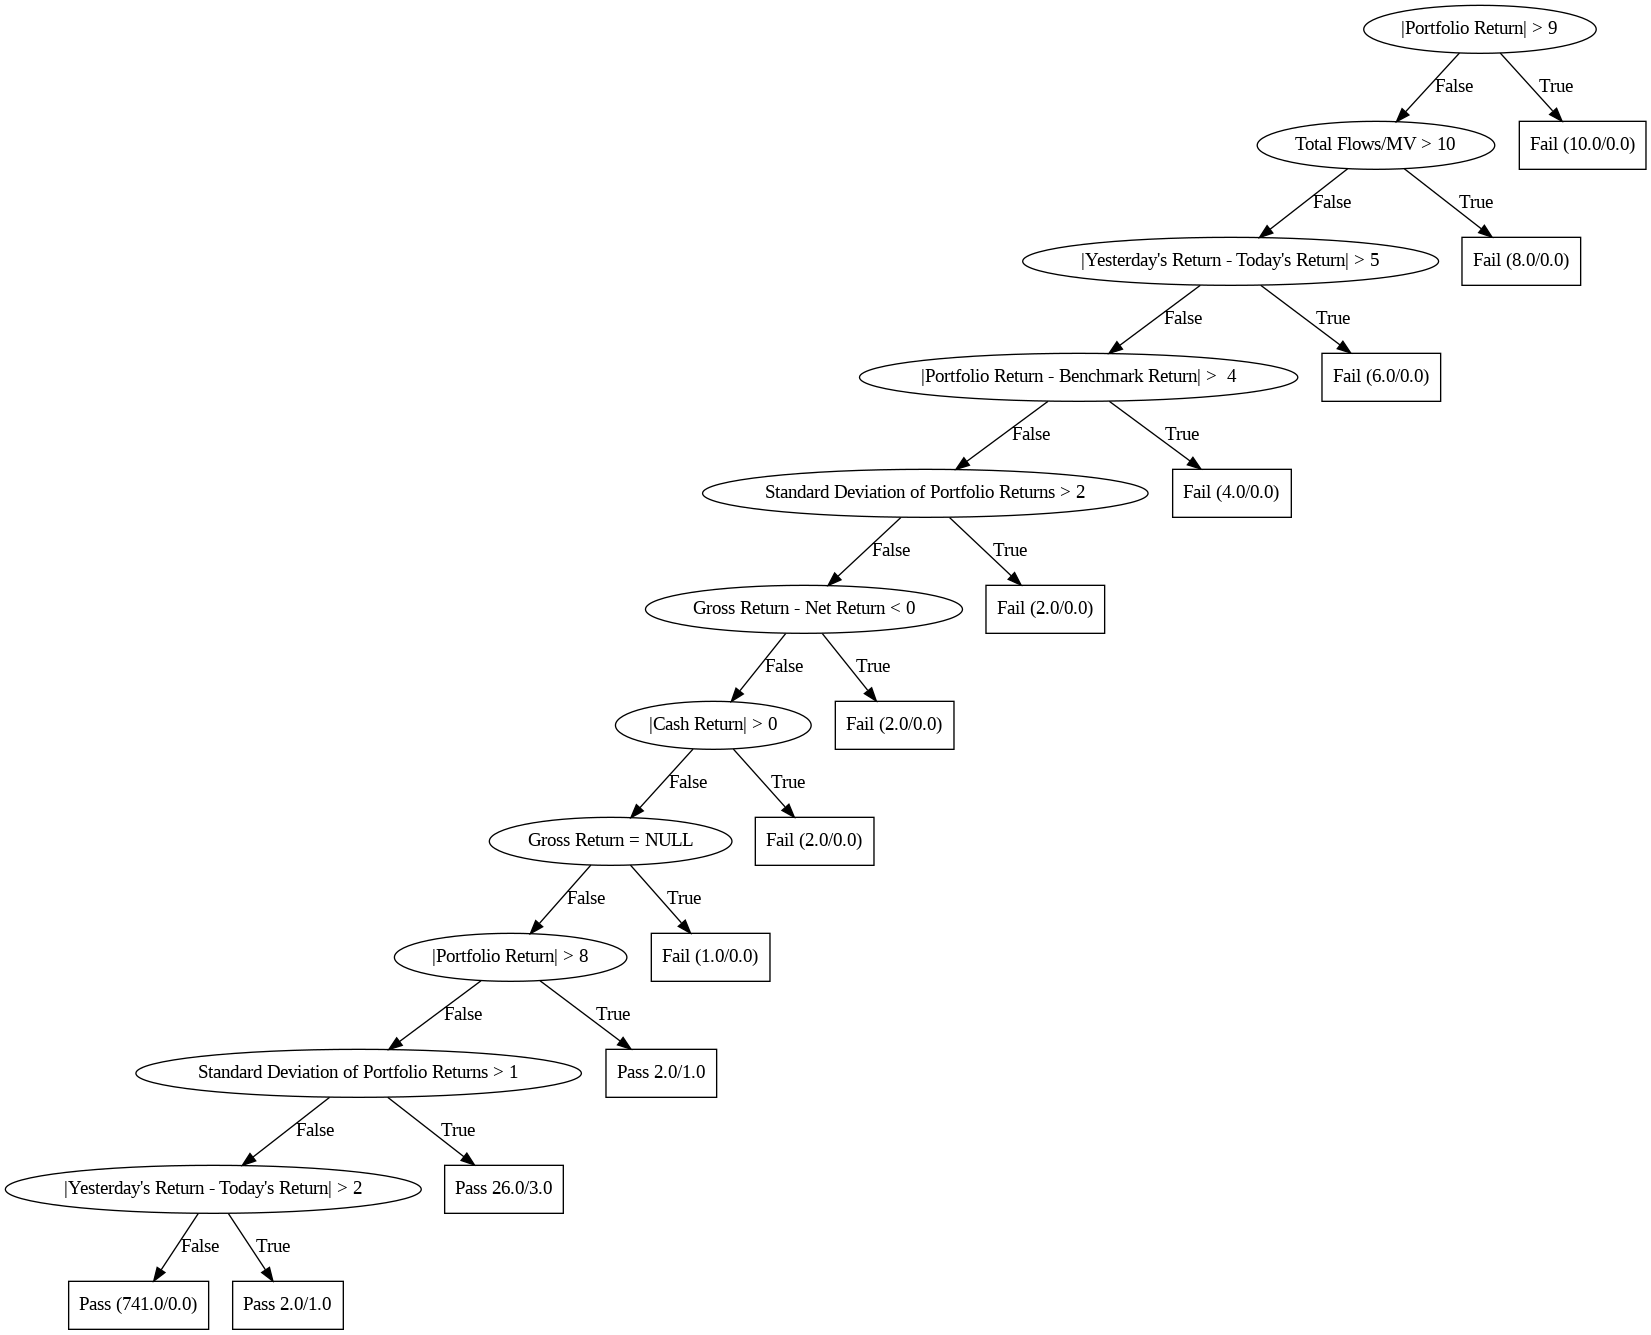

In [19]:
threshold = 0.05
pruned_dec_tree = prune_tree(production_rules, threshold)

ptree = rules_to_tree(pruned_dec_tree)
# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
ptree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename=f'tree{threshold}', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import display, Image, Markdown
Markdown("### Pruned Tree")
Image(filename=f'tree{threshold}.png')

In [20]:
def print_ptree(node, indent=""):
    if node.label is not None:
        print(indent + "Decision:", node.label)
    else:
        for value, subtree in node.branches.items():
            print(indent + f"{node.attribute} = {value}")
            print_ptree(subtree, indent + "  ")

print(print_ptree(ptree))
# print(print_ptree(tree))

|Portfolio Return| > 9 = False
  Total Flows/MV > 10 = False
    |Yesterday's Return - Today's Return| > 5 = False
      |Portfolio Return - Benchmark Return| >  4 = False
        Standard Deviation of Portfolio Returns > 2 = False
          Gross Return - Net Return < 0 = False
            |Cash Return| > 0 = False
              Gross Return = NULL = False
                |Portfolio Return| > 8 = False
                  Standard Deviation of Portfolio Returns > 1 = False
                    |Yesterday's Return - Today's Return| > 2 = False
                      Decision: Pass (741.0/0.0)
                    |Yesterday's Return - Today's Return| > 2 = True
                      Decision: Pass 2.0/1.0
                  Standard Deviation of Portfolio Returns > 1 = True
                    Decision: Pass 26.0/3.0
                |Portfolio Return| > 8 = True
                  Decision: Pass 2.0/1.0
              Gross Return = NULL = True
                Decision: Fail (1.0/0.0)
        